In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
import mne
from mne_connectivity import spectral_connectivity_epochs
from spectral_connectivity import Multitaper, Connectivity
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
import time
from matplotlib.patches import FancyArrowPatch
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import scipy

In [ ]:
#DEFINING FUNCTIONS

In [2]:
scenario_list = ['scenario_1', 'scenario_2', 'scenario_3']

def simulate_scenario(scenario):
    sfreq = 250 # Hz
    tmin = 0 # s
    tmax = 100 # s
    time = np.arange(tmin, tmax, 1/sfreq) 

    f1 = np.random.randint(1,41)  #literature value = 0.125
    f2 = np.random.randint(1,41)   #literature value = 0.25
    f3 = np.random.randint(1,41)  #literature value = 0.10

    signal1 = np.sin(2*np.pi*f1*time)
    signal2 = np.sin(2*np.pi*f2*time)
    signal3 = np.sin(2*np.pi*f3*time)

    #np.random.seed(1000)
    noise1 = np.random.randn(len(time))
    noise2 = np.random.randn(len(time))
    noise3 = np.random.randn(len(time))

     #gains
    g1 = g2 = g3 = 1

    alpha1 = np.random.uniform(0.01, 0.5)
    alpha2 = np.random.uniform(0.01, 0.5)
    alpha3 = np.random.uniform(0.01, 0.5)

    snr1 = g1/alpha1
    snr2 = g2/alpha2
    snr3 = g3/alpha3

    #in radians  #randomize between 0 and 2pi, uniformly distributed
    phase_3_1 = np.random.uniform(0,2)*np.pi
    phase_3_2 = np.random.uniform(0,2)*np.pi
    phase_1_2 = np.random.uniform(0,2)*np.pi

    #delays in seconds
    tau3_1 = phase_3_1/(2*np.pi*f1) #from 3 to 1
    tau3_2 = phase_3_2/(2*np.pi*f2) #from 3 to 2
    tau1_2 = phase_1_2/(2*np.pi*f3) #from 1 to 2
    
    #Time lags in samples
    lag3_1 = np.int64(np.round(tau3_1*f1))
    lag3_2 = np.int64(np.round(tau3_2*f2))
    lag1_2 = np.int64(np.round(tau1_2*f3))

    coefficient_dict = {'scenario_1':{'c_3_1': 1, 'c_3_2':1, 'c_1_2':0},
                        'scenario_2':{'c_3_1': 1, 'c_3_2':0, 'c_1_2':1},
                        'scenario_3':{'c_3_1': 0, 'c_3_2': 0, 'c_1_2':0}}

    c_3_1 = coefficient_dict[scenario]['c_3_1']
    c_3_2 = coefficient_dict[scenario]['c_3_2']
    c_1_2 = coefficient_dict[scenario]['c_1_2']
    
    y3 = (g1*signal3) + noise3*snr3
    y1 = (g2*signal1) + noise1*snr1 + c_3_1*np.roll(y3, lag3_1)
    y2 = (g3*signal2) + noise2*snr2 + c_3_2*np.roll(y3, lag3_2) + c_1_2*np.roll(y1, lag1_2)

    if scenario == 'scenario_3':
        L = np.random.uniform(-1,1,size=(3,3))
    else:
        L = np.identity(3)
    

    z1, z2, z3 = L @ np.array([y1, y2, y3])

    return[z1, z2, z3]

In [3]:
def simulated_raw(signals):
    sim_data = np.array(signals)
    info = mne.create_info(ch_names=["y1", "y2", "y3"], ch_types=["eeg"]*3, sfreq=250)
    simulated_raw = mne.io.RawArray(sim_data, info)
    return simulated_raw

In [4]:
def estimate_conn_undirected(method, data):
    epochs_1 = mne.make_fixed_length_epochs(simulated_raw(data), duration=1)
    
    mne_con = spectral_connectivity_epochs(epochs_1, method=method, sfreq=250, fmin=8, fmax=13, 
                                           fskip=0, faverage=False,
                                           mt_low_bias=True, block_size=1000, n_jobs=1, 
                                           verbose=None)
    con_mat = mne_con.get_data(output="dense")
    con_mat_normalized = (con_mat - con_mat.min())/(con_mat.max() - con_mat.min())
    return con_mat_normalized

In [5]:
def estimate_conn_directed(method, data):
    epochs_2 = mne.make_fixed_length_epochs(simulated_raw(data), duration=8)
    
    m = Multitaper(time_series=np.array(epochs_2.get_data()).transpose(2, 0, 1), sampling_frequency=250)
    c = Connectivity(fourier_coefficients=m.fft(), frequencies=m.frequencies, time=m.time)    
    con = getattr(c, method)()
    con_mat = np.nan_to_num(con.squeeze())[80:131].transpose(1,2,0)
    con_mat_normalized = (con_mat - con_mat.min())/(con_mat.max() - con_mat.min())
    return con_mat_normalized

In [ ]:
#DEFINING GROUND TRUTHS AND METHODS

In [6]:
#format: (1,2),(1,3),(2,3)
#'scenario_1B':np.array([1,1,1]), 'scenario_2B':np.array([1,1,1])

ground_truth_dict = {'scenario_1':np.array([[0,0,0],
                                                 [0,0,0],
                                                 [1,1,0]]),
                     'scenario_2':np.array([[0,0,0],
                                            [1,0,0],
                                            [1,0,0]]),
                     'scenario_3':np.array([[0,0,0],
                                            [0,0,0],
                                            [0,0,0]])}

undirected_methods = ['coh', 'ciplv','imcoh','wpli2_debiased']

directed_methods = ['generalized_partial_directed_coherence', 
                    'direct_directed_transfer_function', 
                    'pairwise_spectral_granger_prediction']

In [ ]:
#MSE DISTRIBUTION CONFIDENCE INTERVALS - UNDIRECTED METHODS

In [7]:
%%capture

mse_dist_undirected = {}
for scenario, ground_truth in zip(['scenario_1','scenario_3'], [ground_truth_dict['scenario_1'],ground_truth_dict['scenario_3']]) :
    mse_dict = {}
    for method in undirected_methods:
        mse_list = []
        for i in range(100):
            con_mat = estimate_conn_undirected(method,simulate_scenario(scenario))
            con_mat = con_mat.mean(2) 
            calculated = np.array([[con_mat[1][0],con_mat[2][0],con_mat[2][1]]])
            ground_truth_vals = np.array([ground_truth_dict[scenario][1][0],ground_truth_dict[scenario][2][0],ground_truth_dict[scenario][2][1]])
            mse = np.sum((calculated - ground_truth_vals)**2)/3
            mse_list.append(mse)
        mse_dict[method] = mse_list
    mse_dist_undirected[scenario] = mse_dict

KeyboardInterrupt: 

In [8]:
df_list= []
for scenario in mse_dist_undirected.keys():
    df = pd.DataFrame.from_dict(mse_dist_undirected[scenario]).melt(value_name='mse', var_name='method')
    df['scenario'] = scenario
    df_list.append(df)

In [9]:
mse_dist_undirected_df = pd.concat(df_list)

In [10]:
mse_dist_undirected_df.method[mse_dist_undirected_df.method == 'wpli2_debiased'] = 'dwPLI'

/var/folders/cl/8cj5mvt51nbchvsgng871t400000gn/T/ipykernel_1563/2230662560.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  mse_dist_undirected_df.method[mse_dist_undirected_df.method == 'wpli2_debiased'] = 'dwPLI'
/var/folders/cl/8cj5mvt

In [ ]:
#ANOVA

In [11]:
mse_dist_undirected_df

,method,mse,scenario
0,coh,0.156082,scenario_1
1,coh,0.122446,scenario_1
2,coh,0.197330,scenario_1
3,coh,0.249039,scenario_1
4,coh,0.216275,scenario_1
...,...,...,...
395,dwPLI,0.109139,scenario_3
396,dwPLI,0.107099,scenario_3
397,dwPLI,0.328578,scenario_3
398,dwPLI,0.100295,scenario_3


In [12]:
F_vals = {}
p_vals = {}
df1_vals = {}
df2_vals = {}

for scenario in ['scenario_1','scenario_3']:
    anova_results = f_oneway(
        mse_dist_undirected_df[(mse_dist_undirected_df['method'] == 'coh') & (mse_dist_undirected_df['scenario'] == scenario)]['mse'],
        mse_dist_undirected_df[(mse_dist_undirected_df['method'] == 'ciplv')& (mse_dist_undirected_df['scenario'] == scenario)]['mse'],
        mse_dist_undirected_df[(mse_dist_undirected_df['method'] == 'imcoh')& (mse_dist_undirected_df['scenario'] == scenario)]['mse'],
        mse_dist_undirected_df[(mse_dist_undirected_df['method'] == 'dwPLI')& (mse_dist_undirected_df['scenario'] == scenario)]['mse']
    )
    F_vals[scenario] = anova_results.statistic.round(2)
    p_vals[scenario] = "<0.001"
    df1_vals[scenario] = 3
    df2_vals[scenario] = 96

data = [F_vals, p_vals, df1_vals, df2_vals]
pd.DataFrame.from_dict(data).transpose().rename({0:"F value",1:"p value", 2:"df1", 3:"df2"}, axis='columns') 

,F value,p value,df1,df2
scenario_1,20.34,<0.001,3,96
scenario_3,298.81,<0.001,3,96


In [13]:
comparison_pairs = ['ciPLV - Coh', 'ciPLV - dwPLI','ciPLV - imCoh', 'Coh - dwPLI','Coh - imCoh','dwPLI-imCoh']

In [15]:
tukey_dict = {}
for scenario in ['scenario_1','scenario_3']:
    scenario_dict = {}
    meandiffs = []
    p_vals = []
    confints = []
    df = mse_dist_undirected_df[mse_dist_undirected_df['scenario']==scenario]
    tukey = pairwise_tukeyhsd(endog=df['mse'],
                              groups=df['method'],
                              alpha=0.05)
    rounded_meandiffs = np.round(tukey.meandiffs,2)
    meandiffs.extend(list(rounded_meandiffs))
    p_vals.extend(list(tukey.pvalues))
    confint_list = list(tukey.confint)
    confint_list_rounded = []
    for interval in range(len(confint_list)):
        lower = confint_list[interval][0] 
        lower = np.round(lower,2)
        upper = confint_list[interval][1]
        upper = np.round(upper,2)
        confint_list_rounded.append((lower,upper))
    confints.extend(confint_list_rounded)
    scenario_dict['Pairs'] = comparison_pairs
    scenario_dict['Mean difference'] = meandiffs
    scenario_dict['P values'] = list(p_vals)
    scenario_dict['95% Confidence intervals'] = confints
    tukey_dict[scenario] = scenario_dict

In [ ]:
#TABLE FOR PUBLICATION

In [16]:
#pd.options.display.float_format = '{:.2f}'.format

scenario_dfs = []
for scenario in tukey_dict:
    scenario_df = pd.DataFrame(tukey_dict[scenario])
    scenario_df.insert(loc=0,column='Scenario',value=[scenario,"","","","",""])
    scenario_dfs.append(scenario_df)

scenario_df_combined = pd.concat(scenario_dfs)

print(scenario_df_combined.to_latex(float_format="{:0.2e}".format,index=False))

\begin{tabular}{llrrl}
\toprule
Scenario & Pairs & Mean difference & P values & 95% Confidence intervals \\
\midrule
scenario_1 & ciPLV - Coh & -9.00e-02 & 4.88e-04 & (-0.15, -0.03) \\
 & ciPLV - dwPLI & 9.00e-02 & 8.56e-04 & (0.03, 0.14) \\
 & ciPLV - imCoh & 1.00e-02 & 9.94e-01 & (-0.05, 0.06) \\
 & Coh - dwPLI & 1.70e-01 & 4.47e-13 & (0.12, 0.23) \\
 & Coh - imCoh & 9.00e-02 & 1.67e-04 & (0.04, 0.15) \\
 & dwPLI-imCoh & -8.00e-02 & 2.27e-03 & (-0.14, -0.02) \\
scenario_3 & ciPLV - Coh & 3.80e-01 & 1.20e-13 & (0.33, 0.43) \\
 & ciPLV - dwPLI & -1.20e-01 & 4.16e-11 & (-0.17, -0.08) \\
 & ciPLV - imCoh & 5.00e-02 & 1.97e-02 & (0.01, 0.1) \\
 & Coh - dwPLI & -5.00e-01 & 1.20e-13 & (-0.55, -0.46) \\
 & Coh - imCoh & -3.30e-01 & 1.20e-13 & (-0.37, -0.28) \\
 & dwPLI-imCoh & 1.80e-01 & 1.20e-13 & (0.13, 0.22) \\
\bottomrule
\end{tabular}



In [ ]:
#GRAPH - MSE UNDIRECTED METHODS

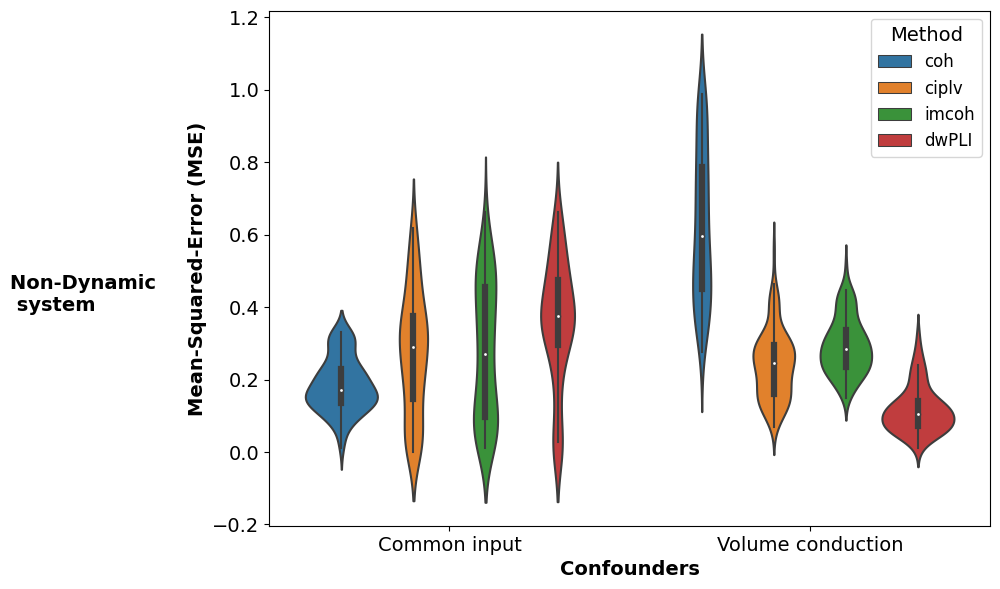

In [17]:
fig,axes = plt.subplots(1,1,figsize=(10,6))
sns.violinplot(mse_dist_undirected_df, x = "scenario", y = "mse", hue = "method")
axes.set_xlabel('Confounders', fontsize=14, fontweight = 'bold')
axes.set(ylabel=None)
axes.set_xticklabels(['Common input', 'Volume conduction'],fontsize=14)
axes.tick_params(labelsize=14)
fig.supylabel('Non-Dynamic \n system',x=0.005, y=0.5,rotation = 'horizontal',fontsize=14, fontweight='bold')
axes.set_ylabel('Mean-Squared-Error (MSE)',fontsize=14, fontweight='bold',loc='center')
axes.legend(title='Method',title_fontsize=14, fontsize=12)
fig.tight_layout()
plt.savefig('figs/simulated_func_non-dynamic.png',dpi=300)

In [ ]:
#MSE DISTRIBUTION CONFIDENCE INTERVALS - DIRECTED METHODS

In [8]:
%%capture
mse_dist_directed_1 = {}
mse_dist_directed_2 = {}

for scenario, ground_truth in zip(scenario_list, ground_truth_dict.values()) :
    mse_dict_1 = {}
    mse_dict_2 = {}
    
    for method in directed_methods:
        mse_list_1 = []
        mse_list_2 = []
        
        for i in range(100):
            con_mat = estimate_conn_directed(method,simulate_scenario(scenario))
            con_mat = np.real(con_mat).mean(2)
            
            select_1 = np.array([[con_mat[1][0],con_mat[2][0],con_mat[2][1]]])
            select_2 = np.array([[con_mat[0][1],con_mat[0][2],con_mat[1][2]]])
            
            ground_truth_1 = np.array([ground_truth_dict[scenario][1][0],ground_truth_dict[scenario][2][0],ground_truth_dict[scenario][2][1]])
            ground_truth_2 = np.array([ground_truth_dict[scenario][0][1],ground_truth_dict[scenario][0][2],ground_truth_dict[scenario][1][2]])
            
            mse_dir_1 = np.sum((select_1 - ground_truth_1)**2)/3
            mse_dir_2 = np.sum((select_2 - ground_truth_2)**2)/3

            
            mse_list_1.append(mse_dir_1)
            mse_list_2.append(mse_dir_2)
            
        mse_dict_1[method] = mse_list_1
        mse_dict_2[method] = mse_list_2
        
    mse_dist_directed_1[scenario] = mse_dict_1
    mse_dist_directed_2[scenario] = mse_dict_2

In [9]:
df_list= []
for scenario in mse_dist_directed_1.keys():
    df = pd.DataFrame.from_dict(mse_dist_directed_1[scenario]).melt(value_name='mse', 
                                                                         var_name='method')
    df['scenario'] = scenario
    df_list.append(df)

mse_dist_directed_1_df = pd.concat(df_list)

df_list= []
for scenario in mse_dist_directed_2.keys():
    df = pd.DataFrame.from_dict(mse_dist_directed_2[scenario]).melt(value_name='mse', 
                                                                         var_name='method')
    df['scenario'] = scenario
    df_list.append(df)

mse_dist_directed_2_df = pd.concat(df_list)

In [10]:
mse_dist_directed_df = pd.concat(df_list)

In [ ]:
#COMMON INPUT, VOLUME CONDUCTION - DIRECTION 1

In [11]:
F_vals = {}
p_vals = {}
df1_vals = {}
df2_vals = {}

for scenario in ['scenario_1','scenario_3']:
    anova_results = f_oneway(
        mse_dist_directed_1_df[(mse_dist_directed_1_df['method'] == 'generalized_partial_directed_coherence') & (mse_dist_directed_1_df['scenario'] == scenario)]['mse'],
        mse_dist_directed_1_df[(mse_dist_directed_1_df['method'] == 'direct_directed_transfer_function')& (mse_dist_directed_1_df['scenario'] == scenario)]['mse'],
        mse_dist_directed_1_df[(mse_dist_directed_1_df['method'] == 'pairwise_spectral_granger_prediction')& (mse_dist_directed_1_df['scenario'] == scenario)]['mse']
    )
    F_vals[scenario] = anova_results.statistic.round(2)
    p_vals[scenario] = "<0.001"
    df1_vals[scenario] = 3
    df2_vals[scenario] = 96

data = [F_vals, p_vals, df1_vals, df2_vals]
pd.DataFrame.from_dict(data).transpose().rename({0:"F value",1:"p value", 2:"df1", 3:"df2"}, axis='columns')

,F value,p value,df1,df2
scenario_1,3.19,<0.001,3,96
scenario_3,0.98,<0.001,3,96


In [12]:
comparison_pairs = ['dDTF-gPDC','dDTF-pSGP','gPDC-pSGP']

In [13]:
tukey_dict = {}
for scenario in ['scenario_1','scenario_3']:
    scenario_dict = {}
    meandiffs = []
    p_vals = []
    confints = []
    df = mse_dist_directed_1_df[mse_dist_directed_1_df['scenario']==scenario]
    tukey = pairwise_tukeyhsd(endog=df['mse'],
                              groups=df['method'],
                              alpha=0.05)
    rounded_meandiffs = np.round(tukey.meandiffs,2)
    meandiffs.extend(list(rounded_meandiffs))
    p_vals.extend(list(tukey.pvalues))
    confint_list = list(tukey.confint)
    confint_list_rounded = []
    for interval in range(len(confint_list)):
        lower = confint_list[interval][0] 
        lower = np.round(lower,2)
        upper = confint_list[interval][1]
        upper = np.round(upper,2)
        confint_list_rounded.append((lower,upper))
    confints.extend(confint_list_rounded)
    scenario_dict['Pairs'] = comparison_pairs
    scenario_dict['Mean difference'] = meandiffs
    scenario_dict['P values'] = list(p_vals)
    scenario_dict['95% Confidence intervals'] = confints
    tukey_dict[scenario] = scenario_dict

In [14]:
pd.options.display.float_format = '{:.2e}'.format

scenario_dfs = []
for scenario in tukey_dict:
    scenario_df = pd.DataFrame(tukey_dict[scenario])
    scenario_df.insert(loc=0,column='Scenario',value=[scenario,"",""])
    scenario_dfs.append(scenario_df)

scenario_df_combined = pd.concat(scenario_dfs)

print(scenario_df_combined.to_latex(float_format="{:0.2e}".format,index=False))

\begin{tabular}{llrrl}
\toprule
Scenario & Pairs & Mean difference & P values & 95% Confidence intervals \\
\midrule
scenario_1 & dDTF-gPDC & 1.00e-02 & 3.29e-01 & (-0.01, 0.04) \\
 & dDTF-pSGP & -1.00e-02 & 5.19e-01 & (-0.03, 0.01) \\
 & gPDC-pSGP & -3.00e-02 & 3.28e-02 & (-0.05, -0.0) \\
scenario_3 & dDTF-gPDC & 1.00e-02 & 4.31e-01 & (-0.01, 0.02) \\
 & dDTF-pSGP & 1.00e-02 & 4.61e-01 & (-0.01, 0.02) \\
 & gPDC-pSGP & -0.00e+00 & 9.98e-01 & (-0.01, 0.01) \\
\bottomrule
\end{tabular}



In [ ]:
#COMMON INPUT, VOLUME CONDUCTION - DIRECTION 2

In [15]:
F_vals = {}
p_vals = {}
df1_vals = {}
df2_vals = {}
for scenario in ['scenario_1','scenario_3']:
    anova_results = f_oneway(
        mse_dist_directed_2_df[(mse_dist_directed_2_df['method'] == 'generalized_partial_directed_coherence') & (mse_dist_directed_2_df['scenario'] == scenario)]['mse'],
        mse_dist_directed_2_df[(mse_dist_directed_2_df['method'] == 'direct_directed_transfer_function')& (mse_dist_directed_2_df['scenario'] == scenario)]['mse'],
        mse_dist_directed_2_df[(mse_dist_directed_2_df['method'] == 'pairwise_spectral_granger_prediction')& (mse_dist_directed_2_df['scenario'] == scenario)]['mse']
    )
    F_vals[scenario] = anova_results.statistic.round(2)
    p_vals[scenario] = "<0.001"
    df1_vals[scenario] = 3
    df2_vals[scenario] = 96

data = [F_vals, p_vals, df1_vals, df2_vals]
pd.DataFrame.from_dict(data).transpose().rename({0:"F value",1:"p value", 2:"df1", 3:"df2"}, axis='columns') 

,F value,p value,df1,df2
scenario_1,1.67e+01,<0.001,3,96
scenario_3,1.22e+00,<0.001,3,96


In [16]:
tukey_dict = {}
for scenario in ['scenario_1','scenario_3']:
    scenario_dict = {}
    meandiffs = []
    p_vals = []
    confints = []
    df = mse_dist_directed_2_df[mse_dist_directed_2_df['scenario']==scenario]
    tukey = pairwise_tukeyhsd(endog=df['mse'],
                              groups=df['method'],
                              alpha=0.05)
    rounded_meandiffs = np.round(tukey.meandiffs,2)
    meandiffs.extend(list(rounded_meandiffs))
    p_vals.extend(list(tukey.pvalues))
    confint_list = list(tukey.confint)
    confint_list_rounded = []
    for interval in range(len(confint_list)):
        lower = confint_list[interval][0] 
        lower = np.round(lower,2)
        upper = confint_list[interval][1]
        upper = np.round(upper,2)
        confint_list_rounded.append((lower,upper))
    confints.extend(confint_list_rounded)
    scenario_dict['Pairs'] = comparison_pairs
    scenario_dict['Mean difference'] = meandiffs
    scenario_dict['P values'] = list(p_vals)
    scenario_dict['95% Confidence intervals'] = confints
    tukey_dict[scenario] = scenario_dict

In [17]:
pd.options.display.float_format = '{:.2e}'.format

scenario_dfs = []
for scenario in tukey_dict:
    scenario_df = pd.DataFrame(tukey_dict[scenario])
    scenario_df.insert(loc=0,column='Scenario',value=[scenario,"",""])
    scenario_dfs.append(scenario_df)

scenario_df_combined = pd.concat(scenario_dfs)

print(scenario_df_combined.to_latex(float_format="{:0.2e}".format,index=False))

\begin{tabular}{llrrl}
\toprule
Scenario & Pairs & Mean difference & P values & 95% Confidence intervals \\
\midrule
scenario_1 & dDTF-gPDC & 3.00e-02 & 1.22e-02 & (0.01, 0.05) \\
 & dDTF-pSGP & 6.00e-02 & 5.51e-08 & (0.03, 0.08) \\
 & gPDC-pSGP & 3.00e-02 & 1.07e-02 & (0.01, 0.05) \\
scenario_3 & dDTF-gPDC & 0.00e+00 & 8.63e-01 & (-0.01, 0.01) \\
 & dDTF-pSGP & 1.00e-02 & 2.77e-01 & (-0.0, 0.02) \\
 & gPDC-pSGP & 0.00e+00 & 5.68e-01 & (-0.01, 0.01) \\
\bottomrule
\end{tabular}



In [20]:
#INDIRECT CONNECTIONS - DIRECTION 1
scipy.stats.ranksums(mse_dist_directed_1['scenario_2']['generalized_partial_directed_coherence'], mse_dist_directed_1['scenario_2']['direct_directed_transfer_function'])

RanksumsResult(statistic=-0.6010736662330217, pvalue=0.5477909220564307)

In [21]:
#INDIRECT CONNECTIONS - DIRECTION 2
scipy.stats.ranksums(mse_dist_directed_2['scenario_2']['generalized_partial_directed_coherence'], mse_dist_directed_2['scenario_2']['direct_directed_transfer_function'])

RanksumsResult(statistic=-1.5173444989053109, pvalue=0.1291797287706047)

In [ ]:
#GRAPH OF MSE's

In [23]:
def method_abbr(value):
    if value == 'generalized_partial_directed_coherence':
        return "gpdc"
    if value == 'direct_directed_transfer_function':
        return "ddtf"
    if value == 'pairwise_spectral_granger_prediction':
        return "psgp"

mse_dist_directed_1_df['method_abbr'] = df['method'].map(method_abbr)
mse_dist_directed_2_df['method_abbr'] = df['method'].map(method_abbr)

In [24]:
mse_dist_directed_1_df_subset = mse_dist_directed_1_df[(mse_dist_directed_1_df['scenario']=='scenario_1') | (mse_dist_directed_1_df['scenario']=='scenario_3')]

In [25]:
mse_dist_directed_2_df_subset = mse_dist_directed_2_df[(mse_dist_directed_2_df['scenario']=='scenario_1') | (mse_dist_directed_2_df['scenario']=='scenario_3')]

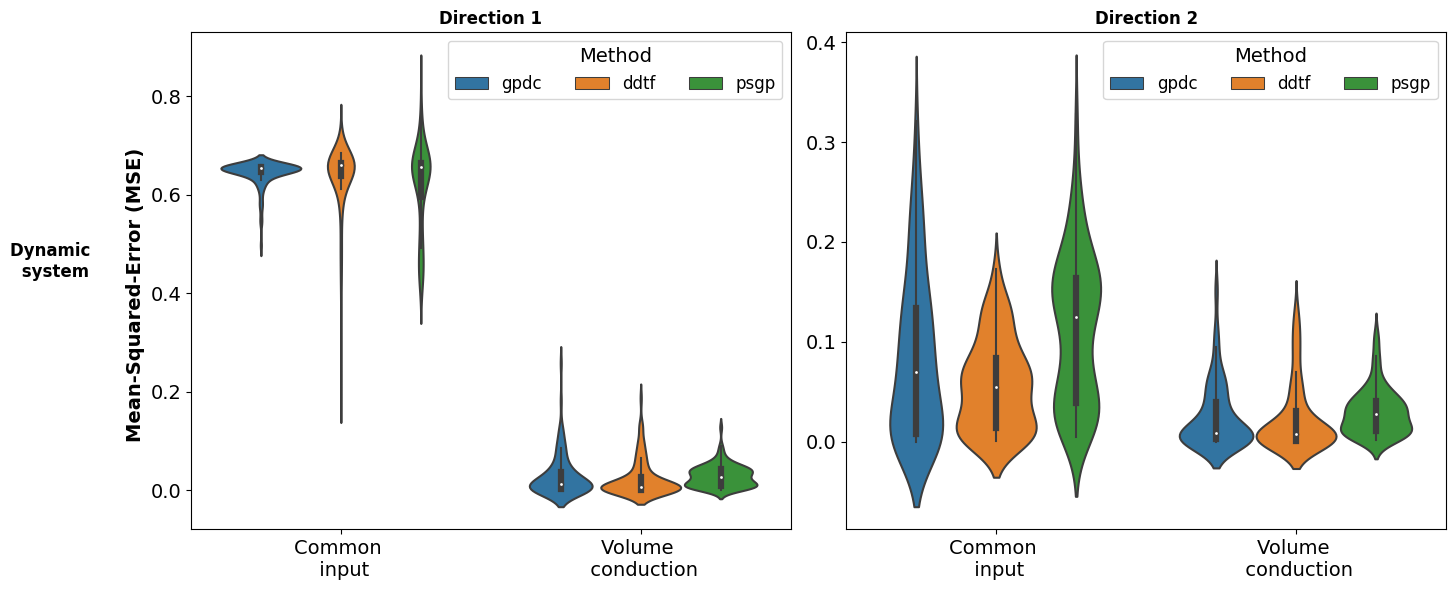

In [26]:
fig,axes = plt.subplots(1,2,figsize=(15,6))
sns.violinplot(mse_dist_directed_1_df_subset, x = "scenario", y = "mse", hue = "method_abbr",ax=axes[0])
sns.violinplot(mse_dist_directed_2_df_subset, x = "scenario", y="mse",hue = "method_abbr", ax=axes[1])
axes[0].set_xticklabels(['Common \n input','Volume \n conduction'],fontsize=14)
axes[1].set_xticklabels(['Common \n input', 'Volume \n conduction'],fontsize=14)
axes[0].set(xlabel=None)
axes[1].set(xlabel=None)
axes[1].set(ylabel=None)
axes[0].set_title('Direction 1',fontweight='bold')
axes[1].set_title('Direction 2',fontweight='bold')
axes[0].tick_params(labelsize=14)
axes[1].tick_params(labelsize=14)
fig.supylabel('Mean-Squared-Error (MSE)',x=0.11, y=0.5,fontsize=14, fontweight='bold')
axes[0].set_ylabel('Dynamic \n system', labelpad=70,rotation = 'horizontal',fontsize=12, fontweight='bold',loc='center')
axes[0].legend(title='Method',title_fontsize=14, fontsize=12,ncol=3)
axes[1].legend(title='Method',title_fontsize=14, fontsize=12,ncol=3)
fig.tight_layout()
plt.savefig('figs/simulated_eff_non-dynamic.png',dpi=300)

In [ ]:
#GRAPH - INDIRECT CONNECTIONS

In [27]:
mse_dist_directed_1_df_subset_scen2 = mse_dist_directed_1_df[(mse_dist_directed_1_df['scenario']=='scenario_2') & (mse_dist_directed_1_df['method_abbr']!='psgp')]

In [28]:
mse_dist_directed_2_df_subset_scen2 = mse_dist_directed_2_df[(mse_dist_directed_2_df['scenario']=='scenario_2') & (mse_dist_directed_2_df['method_abbr']!='psgp')]

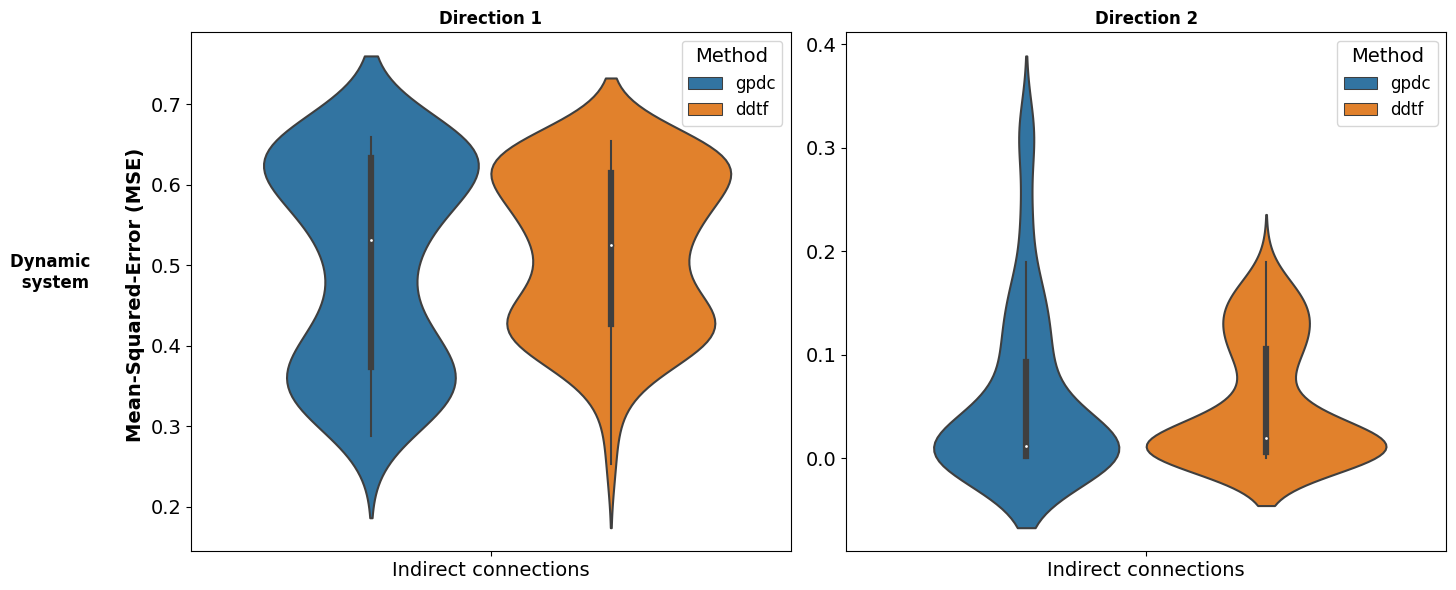

In [29]:
fig,axes = plt.subplots(1,2,figsize=(15,6))
sns.violinplot(mse_dist_directed_1_df_subset_scen2, x = "scenario", y = "mse", hue = "method_abbr",ax=axes[0])
sns.violinplot(mse_dist_directed_2_df_subset_scen2, x = "scenario", y="mse",hue = "method_abbr", ax=axes[1])
axes[0].set_xticklabels(['Indirect connections'],fontsize=14)
axes[1].set_xticklabels(['Indirect connections'],fontsize=14)
axes[0].set(xlabel=None)
axes[1].set(xlabel=None)
axes[1].set(ylabel=None)
axes[0].set_title('Direction 1',fontweight='bold')
axes[1].set_title('Direction 2',fontweight='bold')
axes[0].tick_params(labelsize=14)
axes[1].tick_params(labelsize=14)
fig.supylabel('Mean-Squared-Error (MSE)',x=0.11, y=0.5,fontsize=14, fontweight='bold')
axes[0].set_ylabel('Dynamic \n system', labelpad=70,rotation = 'horizontal',fontsize=12, fontweight='bold',loc='center')
axes[0].legend(title='Method',title_fontsize=14, fontsize=12)
axes[1].legend(title='Method',title_fontsize=14, fontsize=12)
fig.tight_layout()
plt.savefig('figs/simulated_eff_non-dynamic_indirect.png',dpi=300)